In [56]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

import os
import random

In [76]:
from google.colab import files
uploaded = files.upload()

#здесь не сделана проверка на количество файлов, имя файла и расширение,
#потому что в конкретно этом случае это не так важно
filename = list(uploaded.keys())[0]

with tarfile.open(filename, 'r') as tar:
    tar.extractall("/content/")

In [77]:
base_dir = os.getcwd()

#создаю директории для тестовых и тренировочных данных, чтобы потом 
#использовать названия директорий как метки, а из директорий создать
#image_generator, чтобы искусственно увеличить датасет
test_dir = os.path.join(base_dir, "internship_data/test")
train_dir = os.path.join(base_dir, "internship_data/train")

test_dir_man = os.path.join(test_dir, "male")
test_dir_women = os.path.join(test_dir, "female")

train_dir_man = os.path.join(train_dir, "male")
train_dir_women = os.path.join(train_dir, "female")

os.makedirs(test_dir_man)
os.makedirs(test_dir_women)
os.makedirs(train_dir_man)
os.makedirs(train_dir_women)

FileExistsError: ignored

In [4]:
man_dir = os.path.join(base_dir,"internship_data/male/") 
women_dir = os.path.join(base_dir,"internship_data/female/")

In [78]:
#получаю список названий фотографий в каждой директории
man_photos = os.listdir(man_dir)
women_photos = os.listdir(women_dir)

#разбиваю датасет на тестовый и тренировочный в соотношении 20/80
partition = .8
border = int(len(man_photos) * .8)

#перемешиваю фотографии
random.shuffle(man_photos)
random.shuffle(women_photos)

#разделяю на тренировочные и тестовые данные в соответствии с 
#выбранным соотношением
man_train = man_photos[:border]
man_test = man_photos[border:]

women_train = women_photos[:border]
women_test = women_photos[border:]

print(len(man_train), len(man_test))
print(len(women_train), len(women_test))

16 4
16 4


In [6]:
#в этой ячейке закидываю листы с тестовыми и тренировочными фотографиями 
#в соответствующие им директории

for item in man_train:
    os.replace(os.path.join(man_dir, item), os.path.join(train_dir_man, item))

for item in women_train:
    os.replace(os.path.join(women_dir, item), os.path.join(train_dir_women, item))
    
for item in man_test:
    os.replace(os.path.join(man_dir, item), os.path.join(test_dir_man, item))
    
for item in women_test:
    os.replace(os.path.join(women_dir, item), os.path.join(test_dir_women, item))

In [7]:
#проверяю, правильно ли переместила файлы по директориям (по количеству)
print(len(os.listdir(train_dir_man)))
print(len(os.listdir(train_dir_women)))

print(len(os.listdir(test_dir_man)))
print(len(os.listdir(test_dir_women)))

39985
39985
9997
9997


In [48]:
#создаю модель из 4 свёрточных слоёв и 2 полносвязных, один из которых выходной.
#функция активации везде relu, на выходе сигмоида, потому что нужно 
#определить два класса
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
#компилирую модель с функцией потерь бинарная кроссэнтропия, 
#оптимизатором RMSProp и метрикой для проверки accuracy
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
#создаю два генератора, в каждом из которых привожу значения пикселей к
#диапазону [0;1], таким образом, выполняя нормализацию.
#Кроме того, в этой ячейке производится искусственное увеличение датасета.
#На лету фотографии будут случайно поворачиваться и отражаться.


train_datagen = ImageDataGenerator(
    rescale=1./255,                    #нормализация
    width_shift_range=0.2,             #смещение по ширине
    height_shift_range=0.2,            #смещение по высоте
    horizontal_flip=True,              #отражение по горизонтали
    )

#здесь делаю только нормализацию, потому что это тестовые данные, их не надо
#дополнять
test_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
#Говорю генераторам, откуда им брать данные и каким размером они должны быть,
#чтобы попасть на вход нейронной сети. Проделываю это для тестовых и 
#тренировочных данных
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Директория с тренировочными изображениями
        target_size=(150, 150),  # Все изображения будут иметь размер 150*150
        batch_size=64,
        class_mode='binary' #Бинарные метки, поскольку у нас два класса
        )

validation_generator = test_datagen.flow_from_directory(
        test_dir,   # Директория с тестовыми изображениями
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary'
        )

Found 79970 images belonging to 2 classes.
Found 19999 images belonging to 2 classes.


In [52]:
#обучение модели. Количество эпох было выбрано
#опытным путём. Я сравнивала точность и ошибку на тестовых и тренировочных 
#данных, нашла момент, когда точность на тренировочных начала возрастать 
#одновременно с ошибкой на тестовых и взяла эпоху, предшествующую этой.

history = model.fit(
      train_generator,
      steps_per_epoch=1250,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=312,
      verbose=1,
      callbacks = check_accuracy)

Epoch 1/15
1250/1250 [==============================] - 455s 364ms/step - loss: 0.4482 - accuracy: 0.7959 - val_loss: 0.2624 - val_accuracy: 0.8983
Epoch 2/15
1250/1250 [==============================] - 454s 364ms/step - loss: 0.2790 - accuracy: 0.8856 - val_loss: 0.1686 - val_accuracy: 0.9330
Epoch 3/15
1250/1250 [==============================] - 454s 363ms/step - loss: 0.2101 - accuracy: 0.9148 - val_loss: 0.1473 - val_accuracy: 0.9422
Epoch 4/15
1250/1250 [==============================] - 454s 363ms/step - loss: 0.1784 - accuracy: 0.9284 - val_loss: 0.1479 - val_accuracy: 0.9415
Epoch 5/15
1250/1250 [==============================] - 452s 362ms/step - loss: 0.1604 - accuracy: 0.9374 - val_loss: 0.1229 - val_accuracy: 0.9525
Epoch 6/15
1250/1250 [==============================] - 453s 362ms/step - loss: 0.1528 - accuracy: 0.9400 - val_loss: 0.1198 - val_accuracy: 0.9524
Epoch 7/15
1250/1250 [==============================] - 452s 361ms/step - loss: 0.1428 - accuracy: 0.9445 - val_

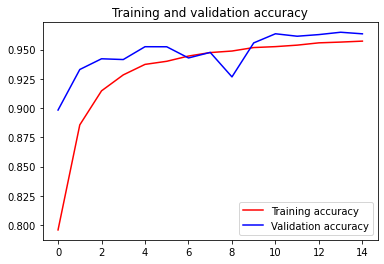

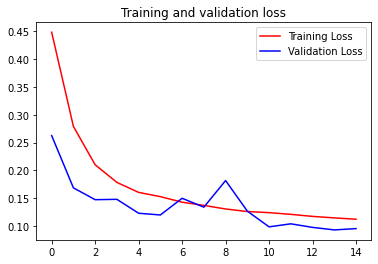

In [54]:
#графики для наглядности точности и потерь
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#сохраняю получившуюся модель модель
model.save("/content/model.h5")
files.download("/content/model_with_RELU.h5") 